In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) (1 − Pr(vampire))$$

In [2]:
pr_positive_vampire = 0.95
pr_positive_mortal= 0.01
pr_vampire = 0.001
pr_positive = pr_positive_vampire * pr_vampire + pr_positive_mortal * (1 - pr_vampire)
pr_vampire_positive = pr_positive_vampire * pr_vampire / pr_positive
pr_vampire_positive

0.08683729433272395

#### Code 3.2: Grid approximate posterior

We are going to use the same function we use on chapter 2 (code 2.3)

In [3]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9, prior=None):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    if prior is None:
        prior = np.repeat(5, grid_points)  # uniform
    elif prior == 'step':
        prior = (p_grid >= 0.5).astype(int)  # truncated
    elif prior == 'peaked':
        prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### 3.3: Sample from a posterior

In [4]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### 3.4 - 3.5: Plotting the samples & density estimate

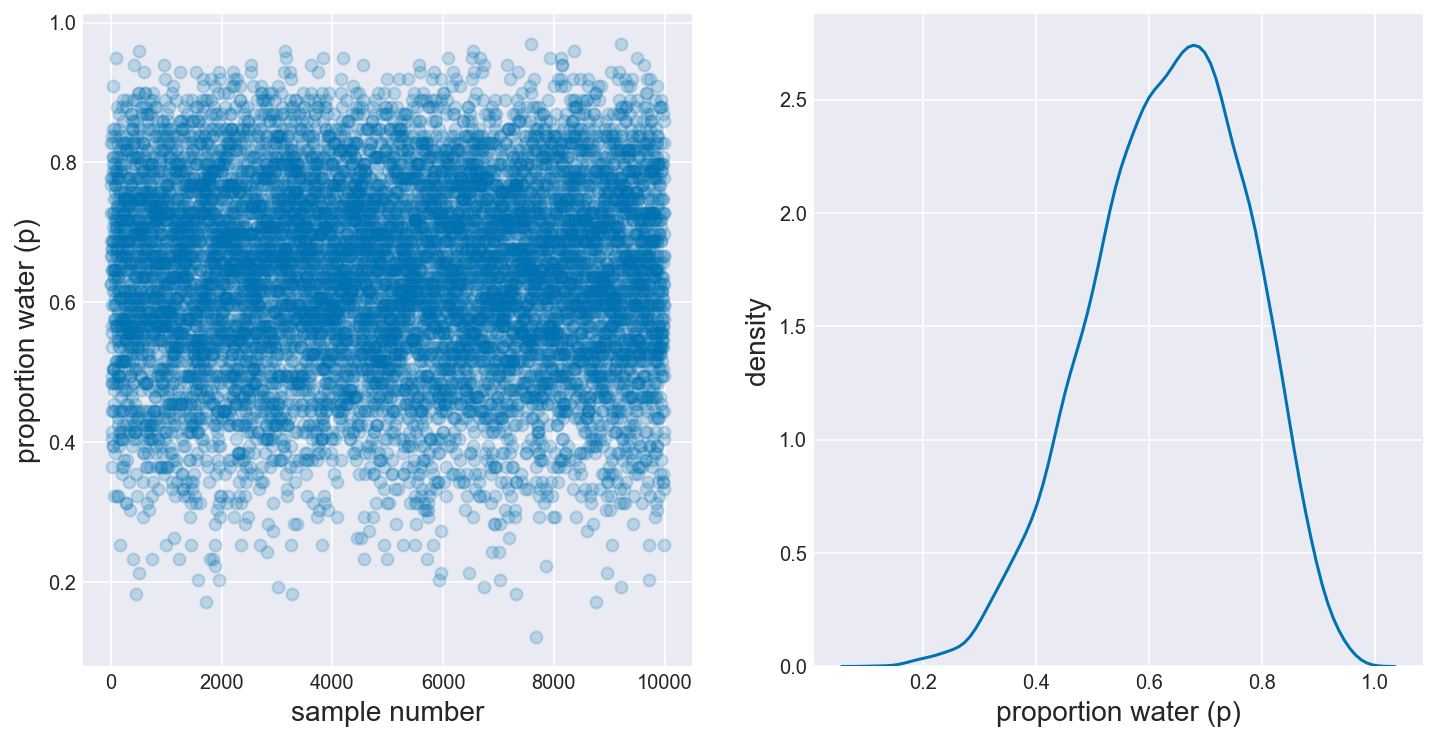

In [5]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
sns.kdeplot(samples, ax=ax1)
ax1.set_xlabel('proportion water (p)', fontsize=14)
ax1.set_ylabel('density', fontsize=14);

#### Code 3.6: Calculate the posterior probability that the proportion of water < 0.5 using grid approximation

In [6]:
sum(posterior[ p_grid < 0.5 ])

0.17183313110747478

#### Code 3.7: Calculate the posterior probability that the proportion of water < 0.5 using samples

In [7]:
sum( samples < 0.5 ) / 1e4

0.1685

#### Code 3.8: How much posterior probability lies between 0.5 and 0.75

In [8]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.617

#### Code 3.9: 80th percentile

In [9]:
np.percentile(samples, 80)

0.7575757575757577

#### Code 3.10: Middle 80% interval

In [18]:
def percentile_interval(samples, prob):
    """
    Analogous to the PI() function referenced in 3.12.
    Given a list of samples and a probability, finds the bounds
    of the central probability
    
    Assumes prob is between 0 and 1
    """
    min_val = (1-prob)/2
    max_val = prob + min_val
    bounds = np.percentile(samples, [min_val * 100, max_val * 100])
    print(f'(min bound) {min_val:.2f}: {bounds[0]:.3f}')
    print(f'(max bound) {max_val:.2f}: {bounds[1]:.3f}')
    return bounds
    

In [19]:
percentile_interval(samples, 0.8)

(min bound) 0.10: 0.455
(max bound) 0.90: 0.808


array([0.45454545, 0.80808081])

In [20]:
np.percentile(samples, [10, 90])

array([0.45454545, 0.80808081])

#### Code 3.11: Grid-aproximation of 3 waters in 3 tosses

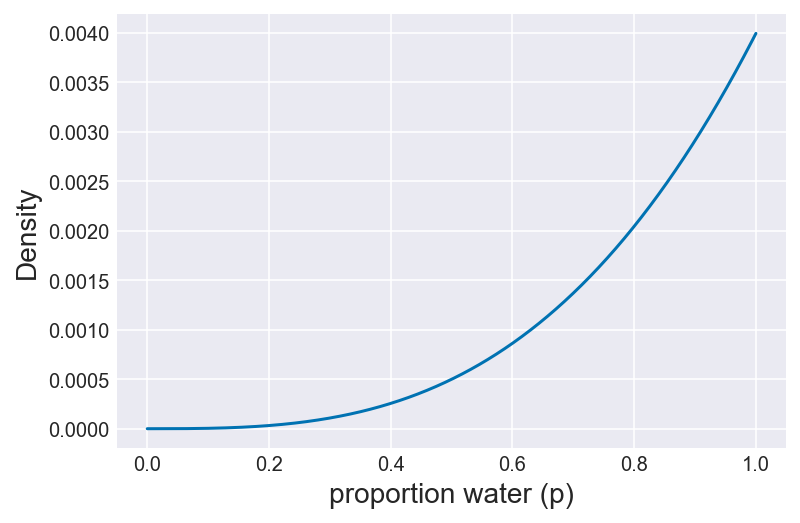

In [21]:
p_grid, posterior = posterior_grid_approx(grid_points=1000,success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 3.12: 50% percentile confidence interval of above graph

In [22]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
percentile_interval(samples, 0.5)

(min bound) 0.25: 0.708
(max bound) 0.75: 0.931


array([0.70770771, 0.93093093])

#### Code 3.13: Highest Posterior Density Interval (HPDI)

In [23]:
pm.hpd(samples, alpha=0.5)

array([0.84184184, 1.        ])

#### Code 3.14: Maximum a posteriori (MAP) estimate

In [24]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15: MAP estimate from samples (aka mode)

In [30]:
stats.mode(samples)[0]

array([0.97197197])

#### Code 3.16: posterior mean & median

In [34]:
np.mean(samples), np.median(samples)

(0.8012266266266266, 0.8418418418418419)

#### Code 3.17

In [22]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

#### Code 3.18 and 3.19

In [23]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

#### Code 3.20

In [30]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [31]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([2])

#### Code 3.22

In [32]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 1, 1, 2, 2, 2, 2, 2, 1, 2])

#### Code 3.23

In [33]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.09027, 0.41965, 0.49008]

#### Code 3.24, 3.25 and 3.26

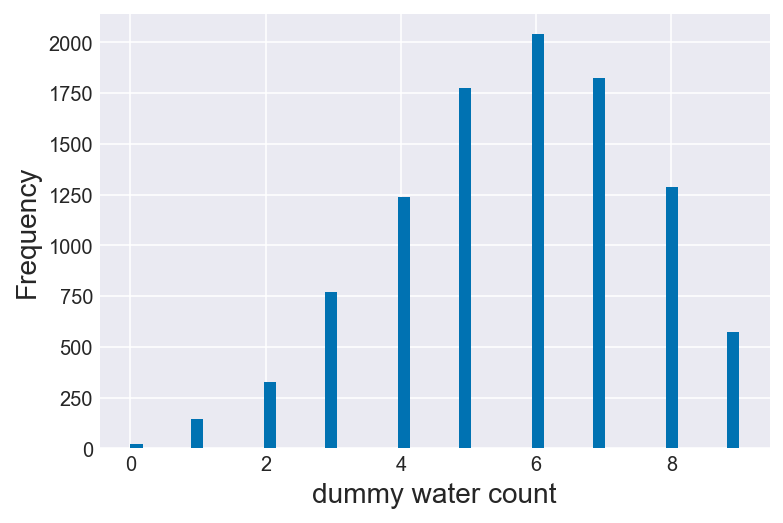

In [61]:
#dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
#dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
dummy_w = stats.binom.rvs(n=9, p=samples)
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

#### Code 3.27

In [62]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [63]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

#### Code 3.29

#### Code 3.30

In [64]:
sum(birth1) + sum(birth2)

111

In [65]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.6.5
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0

